Data Exploration

In [109]:
import sys
from pathlib import Path
# Add the project root directory to sys.path
project_root = Path().resolve().parent
sys.path.append(str(project_root))
from managers import StockDataManager
manager = StockDataManager()
stock_info_df = manager.get_stock_info_df()

ah_df = manager.get_all_ah_candlesticks_df()

In [140]:
stock_info_df

stock_code    name exchange market                   ipo_date area_code  \
0         01210    克莉丝汀       hk      h  2012-02-23T00:00:00+08:00        hk   
1         00001      长和       hk      h  2015-03-18T00:00:00+08:00        hk   
2         00002    中电控股       hk      h  1980-01-02T00:00:00+08:00        hk   
3         00003  香港中华煤气       hk      h  1960-04-11T00:00:00+08:00        hk   
4         00004   九龙仓集团       hk      h  1921-01-01T00:00:00+08:00        hk   
...         ...     ...      ...    ...                        ...       ...   
2649      80291  华润啤酒-R       hk      h  2023-06-19T00:00:00+08:00        hk   
2650      80737  湾区发展-R       hk      h  2012-10-29T00:00:00+08:00        hk   
2651      82333  长城汽车-R       hk      h  2023-06-19T00:00:00+08:00        hk   
2652      82830  南方沙特-R       hk      h  2023-11-29T00:00:00+08:00        hk   
2653      87001  汇贤产业信托       hk      h  2011-04-29T00:00:00+08:00        hk   

      fs_table_type mutual_markets   listing_status        fs_type  \
0     non_financial             []  normally_listed  non_financial   
1     non_financial         ["ah"]  normally_listed  non_financial   
2     non_financial         ["ah"]  normally_listed  non_financial   
3     non_financial         ["ah"]  normally_listed  non_financial   
4     non_financial         ["ah"]  normally_listed  non_financial   
...             ...            ...              ...            ...   
2649  non_financial             []  normally_listed  non_financial   
2650  non_financial             []  normally_listed  non_financial   
2651  non_financial             []  normally_listed  non_financial   
2652  non_financial             []  normally_listed  non_financial   
2653           reit             []  normally_listed           reit   

     stock_code_a  is_ah                last_updated  
0                      0  2024-12-27T00:29:54.106902  
1                      0  2024-12-28T23:43:06.386442  
2                      0  2024-12-28T23:43:06.388184  
3                      0  2024-12-28T23:43:06.389104  
4                      0  2024-12-28T23:43:06.389909  
...           ...    ...                         ...  
2649                   0  2024-12-28T23:43:07.147725  
2650                   0  2024-12-28T23:43:07.148033  
2651                   0  2024-12-28T23:43:07.148286  
2652                   0  2024-12-28T23:43:07.148527  
2653                   0  2024-12-28T23:43:07.148808  

[2654 rows x 13 columns]

Data Manipulation

In [222]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [228]:
def prepare_data(ah_df):
    result_data = []
    
    for stock_code in ah_df.keys():
        # Only process if both HK and A shares data exist
        if 'hk' in ah_df[stock_code]['data'] and 'a' in ah_df[stock_code]['data']:
            hk_df = ah_df[stock_code]['data']['hk'].copy()
            a_df = ah_df[stock_code]['data']['a'].copy()
            
            # Convert dates to datetime for merging
            hk_df['date'] = pd.to_datetime(hk_df['date'])
            a_df['date'] = pd.to_datetime(a_df['date'])
            
            # Calculate ratio by matching dates
            # Merge the dataframes on date and calculate ratio
            a_df_unique = a_df[['date', 'close']].drop_duplicates(subset='date')
            merged_df = pd.merge(hk_df, a_df_unique, on='date', how='left', suffixes=('', '_a'))
            hk_df['ratio'] = merged_df['close_a'] / hk_df['close']
            
            # Add stock_code as symbol to the dataframe
            hk_df['symbol'] = f"{stock_code}"
            result_df = hk_df[['date', 'symbol', 'open', 'high', 'low',
                             'close', 'ratio']]
            result_df.shift(periods=1, axis = 0, fill_value = None)
            result_data.append(result_df)
        else:
            raise ValueError(f"No HK or A shares data for {stock_code}")
        
    # Combine all dataframes
    if result_data:
        final_df = pd.concat(result_data, ignore_index=True)
        final_df["date"] = final_df["date"].dt.tz_localize(None) 
        return final_df
    return pd.DataFrame()

def filter_by_ipo_date(candlestick_df: pd.DataFrame,
                       stock_info_df: pd.DataFrame) -> pd.DataFrame:
    merged = candlestick_df.merge(
        stock_info_df[['stock_code', 'ipo_date']],
        left_on='symbol',
        right_on='stock_code',
        how='left'
    )

    # Convert both date columns to datetime (if not already)
    # and remove any timezone. This step ensures BOTH are tz-naive.
    merged['date'] = pd.to_datetime(merged['date'], errors='coerce')
    merged['date'] = merged['date'].dt.tz_localize(None)

    merged['ipo_date'] = pd.to_datetime(merged['ipo_date'], errors='coerce')
    merged['ipo_date'] = merged['ipo_date'].dt.tz_localize(None)

    # Now you can safely compare
    cond = (merged['ipo_date'].isna()) | (merged['date'] >= merged['ipo_date'])
    filtered = merged.loc[cond].copy()

    filtered.drop(columns=['stock_code'], inplace=True, errors='ignore')
    return filtered


In [234]:
# Prepare data
ah_data_ratios = prepare_data(ah_df)
ah_data_ratios = filter_by_ipo_date(ah_data_ratios, stock_info_df)

In [181]:
ah_data_ratios.dtypes

date        datetime64[ns]
symbol              object
open               float64
high               float64
low                float64
close              float64
ratio              float64
ipo_date    datetime64[ns]
dtype: object

In [237]:
from copy import deepcopy

In [251]:
ah_ratios_1 = deepcopy(ah_data_ratios)

In [254]:
# Pivot the data to have symbols as columns and date as index
close_df = ah_ratios_1.pivot(index='date', columns='symbol', values='close')
close_df

symbol       00038   00107    00168    00177  00187  00300    00317   00323  \
date                                                                          
2014-12-31  5.7100  3.3300  52.6000   9.2600   3.00    NaN  22.2500  2.3200   
2015-01-02  5.7800  3.3800  52.4500   9.1400   2.93    NaN  22.7000  2.3000   
2015-01-05  5.8800  3.3900  50.8500   9.2300   3.13    NaN  23.0500  2.3300   
2015-01-06  5.8600  3.4000  51.8000   9.3400   3.08    NaN  22.6000  2.3500   
2015-01-07  5.9200  3.4200  52.0500   9.3000   3.21    NaN  22.6000  2.4000   
...            ...     ...      ...      ...    ...    ...      ...     ...   
2024-12-19  8.6424  4.6548  62.8648  13.4363   2.99  74.80  11.4165  2.7791   
2024-12-20  8.3024  4.6548  62.9648  13.5163   2.91  74.65  11.3765  2.6991   
2024-12-23  8.1424  4.6848  63.7648  13.6563   2.84  75.75  11.5965  2.6991   
2024-12-24  8.2724  4.6848  65.1148  13.6663   2.88  77.45  11.5165  2.7391   
2024-12-27  8.2624  4.7448  64.2648  13.7263   2.99  76.10  11.6965  2.7591   

symbol       00338   00347  ...    06826    06837    06865    06869    06881  \
date                        ...                                                
2014-12-31  2.2700  6.6000  ...      NaN  19.5200      NaN   6.7000   9.7300   
2015-01-02  2.3200  6.5600  ...      NaN  20.2500      NaN   6.7000  10.4000   
2015-01-05  2.3800  6.8300  ...      NaN  19.6800      NaN   6.7000  10.1200   
2015-01-06  2.3700  6.7700  ...      NaN  19.4400      NaN   6.6800  10.1400   
2015-01-07  2.3600  6.8600  ...      NaN  19.6400      NaN   6.5900  10.2800   
...            ...     ...  ...      ...      ...      ...      ...      ...   
2024-12-19  2.6565  3.2432  ...  44.2786   9.8323  13.0482  15.2851   9.4324   
2024-12-20  2.6365  3.1652  ...  43.9986   9.7523  12.7082  14.9451   9.4324   
2024-12-23  2.6365  3.2042  ...  43.8586   9.7823  12.6482  14.6251   9.4724   
2024-12-24  2.6365  3.2172  ...  44.4186   9.7723  13.4082  14.8651   9.6324   
2024-12-27  2.6565  3.2172  ...  44.2786   9.8123  12.8282  16.5451   9.6524   

symbol      06886  06936    09696   09989  09995  
date                                              
2014-12-31    NaN    NaN      NaN     NaN    NaN  
2015-01-02    NaN    NaN      NaN     NaN    NaN  
2015-01-05    NaN    NaN      NaN     NaN    NaN  
2015-01-06    NaN    NaN      NaN     NaN    NaN  
2015-01-07    NaN    NaN      NaN     NaN    NaN  
...           ...    ...      ...     ...    ...  
2024-12-19  17.38  33.75  29.0331  4.4047  15.46  
2024-12-20  17.24  33.95  29.0831  4.3847  14.76  
2024-12-23  17.40  33.60  29.2331  4.3547  14.80  
2024-12-24  17.74  34.50  29.2331  4.3547  14.82  
2024-12-27  17.76  33.70  29.3331  4.3447  14.60  

[2459 rows x 148 columns]

In [256]:
ratio_df = ah_ratios_1[["date", "symbol", "ratio"]].set_index(["date", "symbol"])
ratio_df

ratio
date       symbol          
2014-12-31 00038   2.280210
2015-01-02 00038        NaN
2015-01-05 00038   2.151361
2015-01-06 00038   2.244027
2015-01-07 00038   2.268581
...                     ...
2024-12-19 09995   2.124838
2024-12-20 09995   2.162602
2024-12-23 09995   2.159459
2024-12-24 09995   2.180162
2024-12-27 09995   2.101370

[327574 rows x 1 columns]

In [259]:
close_df.dtypes

symbol
00038    float64
00107    float64
00168    float64
00177    float64
00187    float64
          ...   
06886    float64
06936    float64
09696    float64
09989    float64
09995    float64
Length: 148, dtype: object

In [257]:
ratio_df.dtypes

ratio    float64
dtype: object

In [260]:
from alphalens.utils import get_clean_factor_and_forward_returns
#将tears.py中的get_values()函数改为to_numpy()
ret = get_clean_factor_and_forward_returns(ratio_df, close_df)# ah_ratios_stacked = ah_ratios_stacked[["date", "symbol", "close", "ratio"]]

/Users/z/PycharmProjects/trading_system/.venv/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
/Users/z/PycharmProjects/trading_system/.venv/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change(period)
/Users/z/PycharmProjects/trading_system/.venv/lib/python3.11/site-packages/alphalens/utils.py:308: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill

Dropped 18.4% entries from factor data: 18.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Quantiles Statistics


min        max      mean       std  count    count %
factor_quantile                                                           
1                0.262730   1.236176  0.958048  0.149894  54461  20.373342
2                0.911667   1.487914  1.203999  0.098614  53071  19.853357
3                1.074362   1.968707  1.428221  0.126363  52931  19.800984
4                1.260336   2.650374  1.792227  0.249017  53072  19.853731
5                1.458809  37.241252  3.430427  3.370369  53780  20.118587

Returns Analysis


1D     5D    10D
Ann. alpha                                     0.013  0.004 -0.007
beta                                           0.224  0.289  0.297
Mean Period Wise Return Top Quantile (bps)     1.982  1.980  1.375
Mean Period Wise Return Bottom Quantile (bps) -1.406 -0.863 -0.760
Mean Period Wise Spread (bps)                  3.387  2.682  1.977

<Figure size 640x480 with 0 Axes>

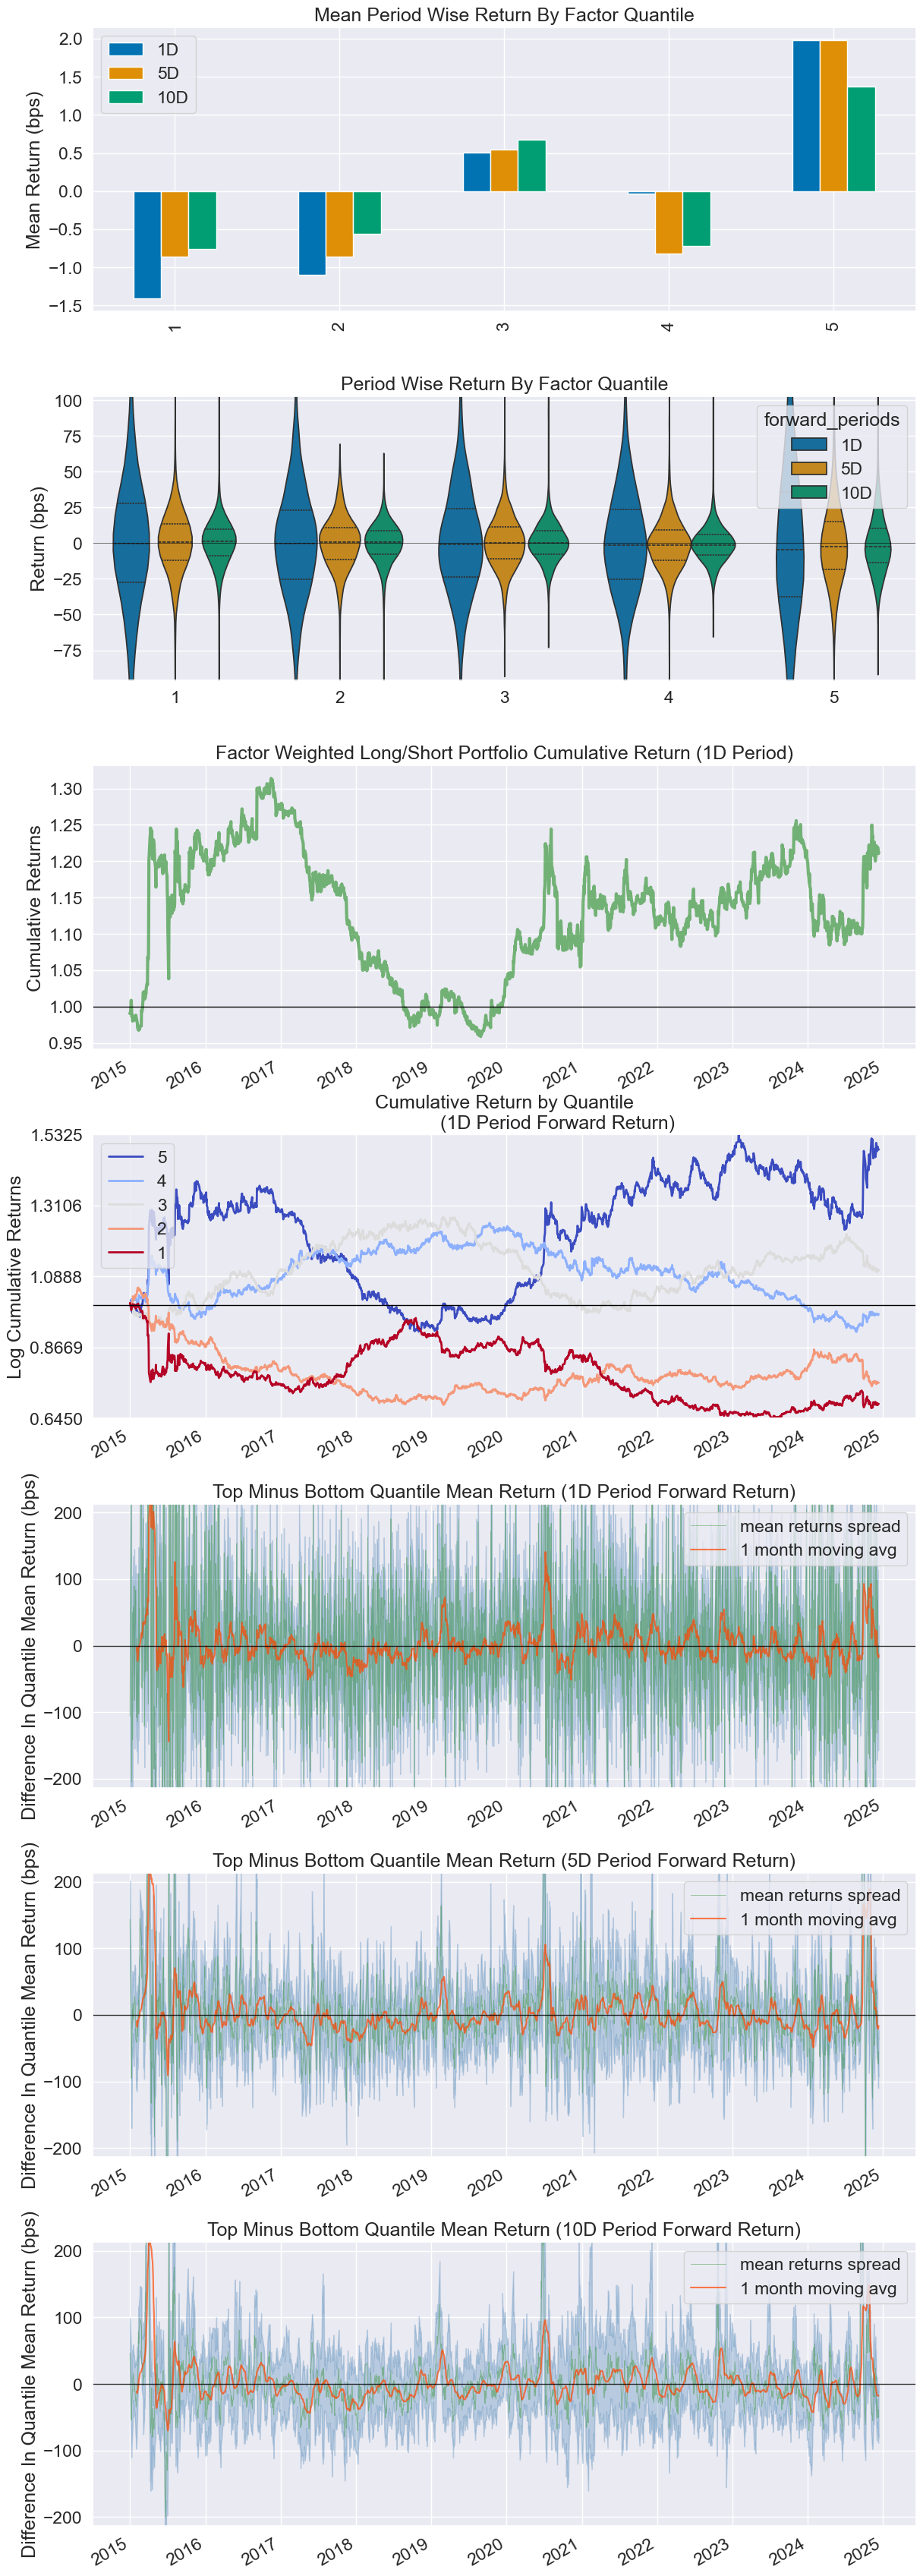

Information Analysis


1D     5D    10D
IC Mean          -0.020 -0.032 -0.038
IC Std.           0.185  0.199  0.203
Risk-Adjusted IC -0.109 -0.159 -0.187
t-stat(IC)          NaN    NaN    NaN
p-value(IC)         NaN    NaN    NaN
IC Skew             NaN    NaN    NaN
IC Kurtosis         NaN    NaN    NaN

/Users/z/PycharmProjects/trading_system/.venv/lib/python3.11/site-packages/alphalens/performance.py:118: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  grouper.append(pd.Grouper(freq=by_time))


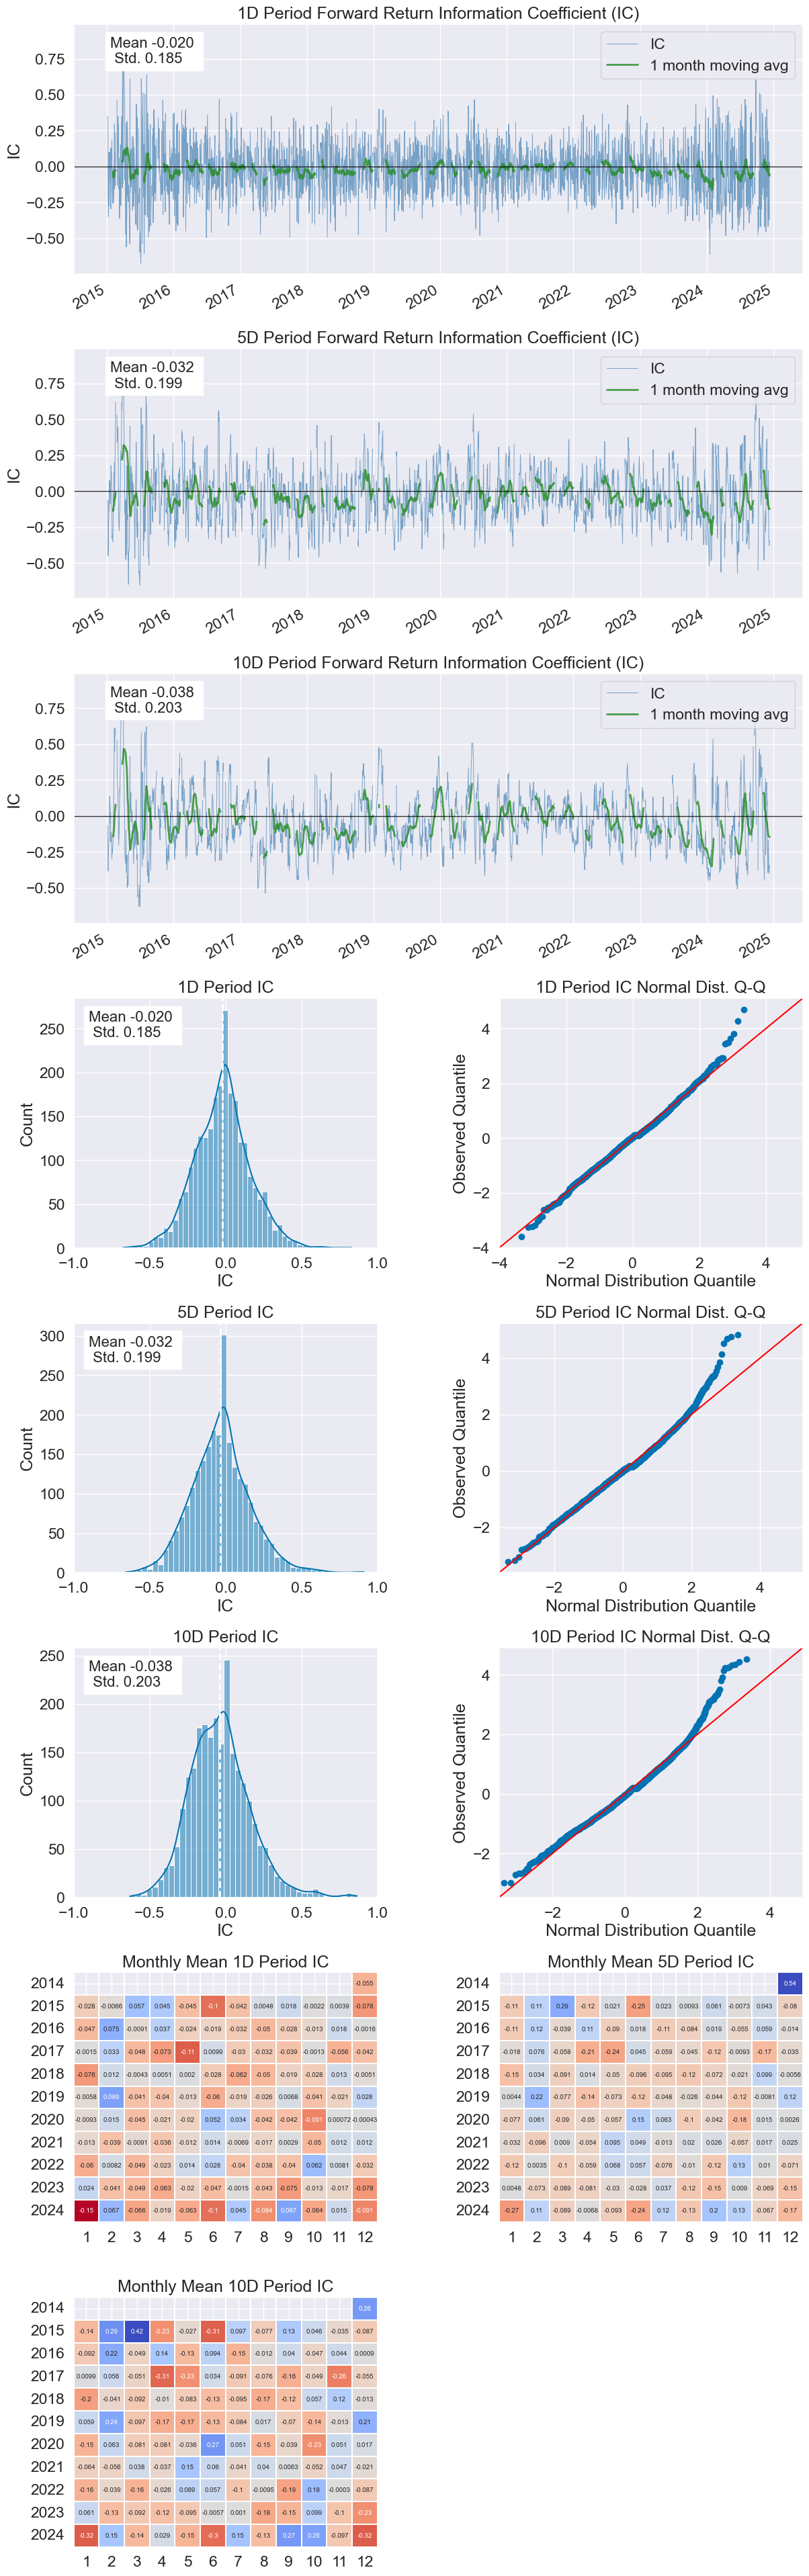

/Users/z/PycharmProjects/trading_system/.venv/lib/python3.11/site-packages/alphalens/utils.py:928: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


Turnover Analysis


1D     5D    10D
Quantile 1 Mean Turnover   0.030  0.052  0.068
Quantile 2 Mean Turnover   0.075  0.132  0.173
Quantile 3 Mean Turnover   0.084  0.149  0.194
Quantile 4 Mean Turnover   0.064  0.119  0.157
Quantile 5 Mean Turnover   0.026  0.053  0.072

1D     5D   10D
Mean Factor Rank Autocorrelation  0.998  0.994  0.99

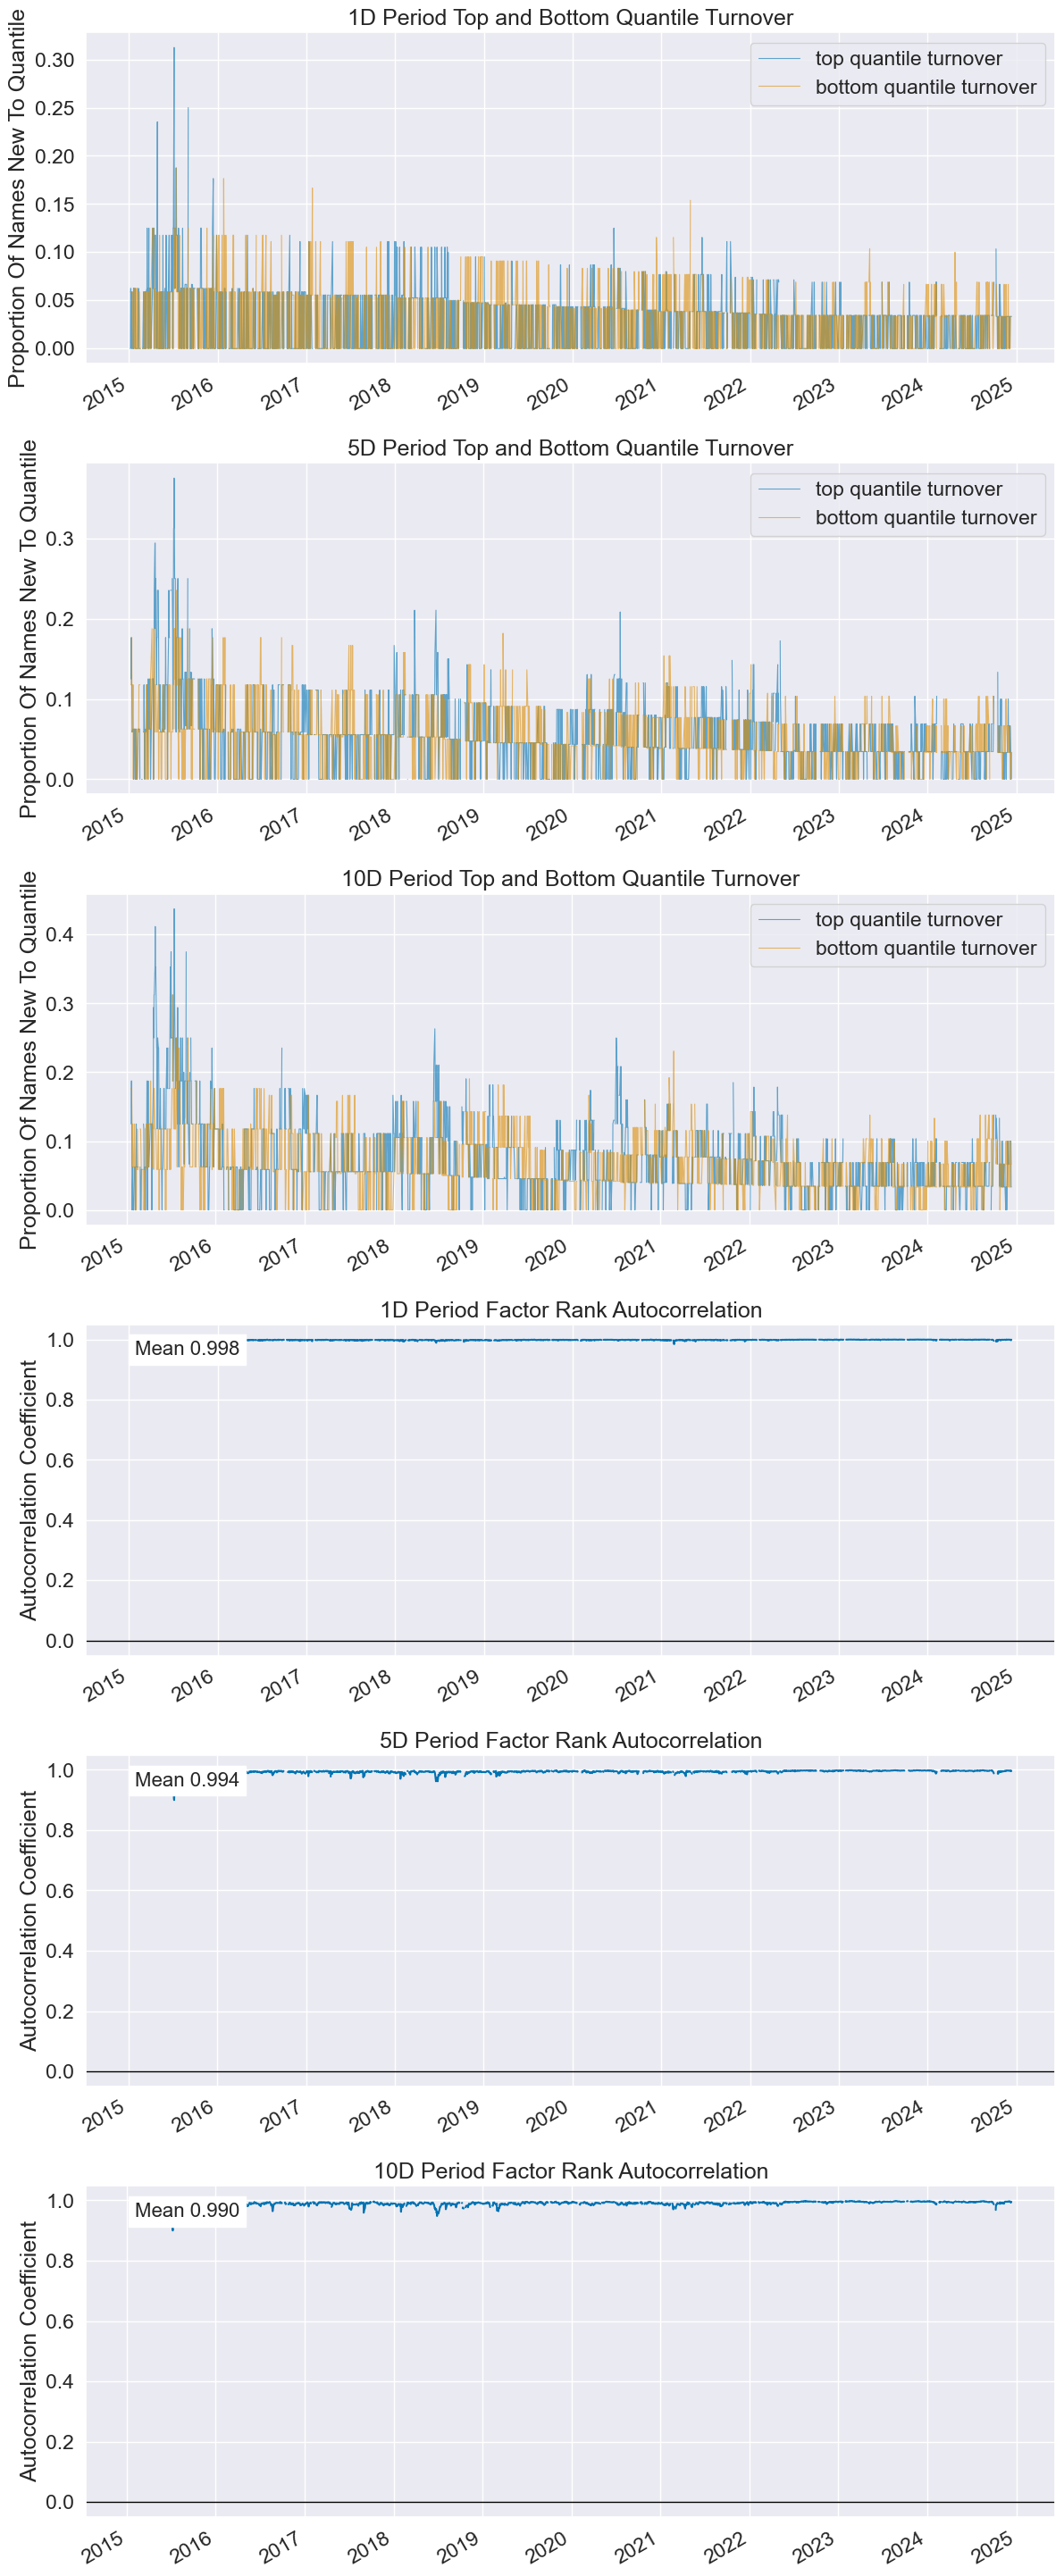

In [261]:
import alphalens
alphalens.tears.create_full_tear_sheet(ret)

In [243]:
print(ah_ratios_stacked.head())

        date symbol  close     ratio
0 2014-12-31  00038   5.71  2.280210
1 2015-01-02  00038   5.78       NaN
2 2015-01-05  00038   5.88  2.151361
3 2015-01-06  00038   5.86  2.244027
4 2015-01-07  00038   5.92  2.268581


In [246]:
ah_ratios_stacked.set_index(["date", "symbol"], inplace=True)

In [248]:
ah_ratios_stacked

close     ratio
date       symbol                 
2014-12-31 00038    5.71  2.280210
2015-01-02 00038    5.78       NaN
2015-01-05 00038    5.88  2.151361
2015-01-06 00038    5.86  2.244027
2015-01-07 00038    5.92  2.268581
...                  ...       ...
2024-12-19 09995   15.46  2.124838
2024-12-20 09995   14.76  2.162602
2024-12-23 09995   14.80  2.159459
2024-12-24 09995   14.82  2.180162
2024-12-27 09995   14.60  2.101370

[327574 rows x 2 columns]

In [233]:
# Count rows with non-null ratio or close values before deletion
count_before = len(ah_data_ratios[ah_data_ratios["ratio"].isna() & ah_data_ratios["close"].isna()])
print(f"Number of rows with non-null ratio or close values: {count_before}")

# Delete all rows where either ratio or close columns contain NaN values
ah_data_ratios = ah_data_ratios[ah_data_ratios["ratio"].notna() | ah_data_ratios["close"].notna()]

Number of rows with non-null ratio or close values: 0


In [221]:
print(ah_data_ratios['close'].isnull().sum())

0


In [217]:
# Debug: check data for specific date
mask1 = ah_data_ratios["date"] == pd.to_datetime("2015-03-11")
mask2 = ah_data_ratios["symbol"] == "02727"
print(ah_data_ratios[mask1 & mask2])

Empty DataFrame
Columns: [date, symbol, open, high, low, close, ratio, ipo_date]
Index: []


In [220]:
import pandas as pd
import numpy as np
import bt


class DebugAlgo(bt.Algo):
    """
    Logs two pieces of information each day:
      - How many candidate stocks have non-NaN data for today
      - The net value of the portfolio

    The results are stored in self.results_dict as:
        results_dict[date] = (count_of_candidates, portfolio_value)
    """
    def __init__(self, ratio_key="ratio_wide"):
        super(DebugAlgo, self).__init__()
        self.ratio_key = ratio_key
        self.results_dict = {}

    def __call__(self, target):
        # 1) Grab ratio data (if you want to see how many stocks are valid in ratio today)
        ratio_data = target.get_data(self.ratio_key)  # e.g. ratio_wide

        # 2) Grab the close prices from target.universe or target.data
        #    By default, target.universe is the same as the main data you pass to Backtest
        close_data = target.universe  

        # 3) For the current date, see which symbols have non-NaN ratio AND non-NaN close
        date = target.now

        # check ratio row
        if date in ratio_data.index:
            row_ratio = ratio_data.loc[date].dropna()
        else:
            row_ratio = pd.Series(dtype=float)

        # check close row
        if date in close_data.index:
            row_close = close_data.loc[date].dropna()
        else:
            row_close = pd.Series(dtype=float)

        # intersection -> symbols that have no NaN in ratio and close
        valid_symbols = row_ratio.index.intersection(row_close.index)
        count_of_candidates = len(valid_symbols)

        # 4) Portfolio net value on this date
        portfolio_value = target.value  # or target.strategy.value

        # 5) Store or print
        self.results_dict[date] = (count_of_candidates, portfolio_value)
        # Optionally: print each day
        print(f"{date} -> {count_of_candidates} candidates, portfolio value = {portfolio_value:.2f}")

        return True


class RunOnFirstTradingDayOfMonth(bt.Algo):
    """
    This algo returns True only if the current date target.now
    is the *first trading day* of that month (based on actual data index).
    We store those dates (once) by scanning the data's index to find
    the earliest date for each month.
    """
    def __init__(self):
        super(RunOnFirstTradingDayOfMonth, self).__init__()
        self.first_days = None

    def __call__(self, target):
        # Build self.first_days set once
        if self.first_days is None:
            dts = target.data.dropna(how="all").index
            self.first_days = set()
            last_month = None
            for dt in dts:
                month_key = (dt.year, dt.month)
                if month_key != last_month:
                    self.first_days.add(dt)
                    last_month = month_key

        # Return True if today's date is one of those "first trading days"
        return target.now in self.first_days


class SelectTop10ByRatio(bt.Algo):
    """
    On the days we return True (from RunOnFirstTradingDayOfMonth),
    this picks the top 10 stocks by ratio from ratio_data_key.
    BUT first ensure both the close price and ratio are not NaN on the current date.
    """
    def __init__(self, ratio_data_key="ratio_wide"):
        super(SelectTop10ByRatio, self).__init__()
        self.ratio_data_key = ratio_data_key

    def __call__(self, target):
        ratio_data = target.get_data(self.ratio_data_key)
        # If no ratio row for today, do nothing
        if target.now not in ratio_data.index:
            target.temp["top10"] = []
            return True

        # 1) Get ratio row and drop NaNs
        row = ratio_data.loc[target.now].dropna()

        # 2) Also ensure these symbols have a valid (non-NaN) close price today
        valid_close_today = target.universe.loc[target.now].dropna()
        valid_symbols = row.index.intersection(valid_close_today.index)

        # 3) Re-filter ratio row, keep only symbols that actually have a price today
        row = row.loc[valid_symbols]

        # 4) Also look ahead 1 month to ensure data exists
        # This helps avoid entering positions that may have missing data next month
        next_month = target.now + pd.DateOffset(months=1)
        next_dates = target.universe.index[target.universe.index >= next_month]
        if len(next_dates) > 0:
            next_date = next_dates[0]
            next_valid = target.universe.loc[next_date].dropna()
            valid_symbols = row.index.intersection(next_valid.index)
            row = row.loc[valid_symbols]

        # 5) pick top 10 by ratio 
        if len(row) >= 10:
            top10 = row.nlargest(10).index.tolist()
        else:
            # If less than 10 valid stocks, use all available
            top10 = row.index.tolist()

        # Save to temp
        target.temp["top10"] = top10
        return True


class WeighEquallyTop10(bt.Algo):
    """
    Create the weights dict with each stock in top10 having equal weight.
    If no top10 is found, hold zero positions.
    """
    def __call__(self, target):
        top10 = target.temp.get("top10", [])
        if len(top10) == 0:
            # empty weighting
            target.temp["weights"] = {}
        else:
            w = 1.0 / len(top10)
            target.temp["weights"] = {name: w for name in top10}
        return True


def run_simplified_backtest(ah_data_ratios: pd.DataFrame):
    """
    This function runs a simplified backtest using the bt framework:
      - On the *first trading day of each month*, pick top 10 ratio stocks.
      - Immediately buy equally among those 10 stocks (rebalancing the entire portfolio).
      - Start capital is 1,000,000.
      - The input 'ah_data_ratios' must be timezone-naive and sorted ascending by date.
      - Backtest between 2024-01-01 and 2024-12-26 (naive dates).
    
    Required columns in ah_data_ratios:
        ['date', 'symbol', 'close', 'ratio']
    (Other columns ignored here.)

    Returns
    -------
    bt.Result
    """

    # 1) Sort the raw DataFrame by date (assumed naive, ascending).
    df = ah_data_ratios.copy().sort_values(["date", "symbol"])

    # 2) Create wide data frames:
    close_wide = df.pivot(index="date", columns="symbol", values="close").dropna(how = "all")
    ratio_wide = df.pivot(index="date", columns="symbol", values="ratio").dropna(how = "all")

    # 3) Trim date range
    start_date, end_date = pd.to_datetime("2014-01-01"), pd.to_datetime("2024-12-26")
    close_wide = close_wide.loc[(close_wide.index >= start_date) & (close_wide.index <= end_date)]
    ratio_wide = ratio_wide.loc[(ratio_wide.index >= start_date) & (ratio_wide.index <= end_date)]

    # 4) Define Strategy
    # We'll run daily, but only place trades on the first trading day of each month.
    # On that day, we pick top 10 ratio and allocate equally.
    strategy = bt.Strategy(
        "Top10Monthly",
        algos=[
            bt.algos.RunDaily(),             # Check daily
            RunOnFirstTradingDayOfMonth(),   # True only on the first day in a month
            SelectTop10ByRatio("ratio_wide"),
            WeighEquallyTop10(),
            DebugAlgo(),
            bt.algos.Rebalance(),
        ],
    )

    # 5) Build backtest
    backtest = bt.Backtest(
        strategy=strategy,
        data=close_wide,
        initial_capital=1_000_000,
        name="AH_Simplified",
        additional_data={"ratio_wide": ratio_wide},
    )

    # 6) Run
    res = bt.run(backtest)
    return res


result = run_simplified_backtest(ah_data_ratios)
print(result.display())


  0%|          | 0/1 [00:00<?, ?it/s]

2015-01-05 00:00:00 -> 81 candidates, portfolio value = 1000000.00
2015-02-02 00:00:00 -> 79 candidates, portfolio value = 935935.71
2015-03-02 00:00:00 -> 82 candidates, portfolio value = 975466.87


Exception: Position is open (non-zero: 21438.0) and latest price is NaN for security 02727 on 2015-03-11 00:00:00. Cannot update node value.

In [183]:
result.get_transactions()

price  quantity
Date       Security                   
2015-02-02 00038      5.3500   18691.0
           00187      3.1100   32154.0
           00568      3.1100   32154.0
           00719      3.6400   27472.0
           01033      2.5100   39840.0
...                      ...       ...
2024-12-02 03347     36.1111     461.0
           06127     27.8690      93.0
           06936     33.8000    3866.0
           09696     31.9831     286.0
           09989      4.4747    2839.0

[1294 rows x 2 columns]

In [166]:
result.display_lookback_returns()



AH_Simplified
mtd           1.02%
3m           44.57%
6m           48.18%
ytd          29.62%
1y           37.07%
3y           -1.63%
5y            8.92%
10y           2.44%
incep         2.44%

In [171]:
result.get_transactions



<bound method Result.get_transactions of {'AH_Simplified': <ffn.core.PerformanceStats object at 0x31b0b3350>}>

In [ ]:
(datetime.now() - timedelta(days=3650)).strftime("%Y-%m-%d")

<Axes: title={'center': 'Equity Progression'}>

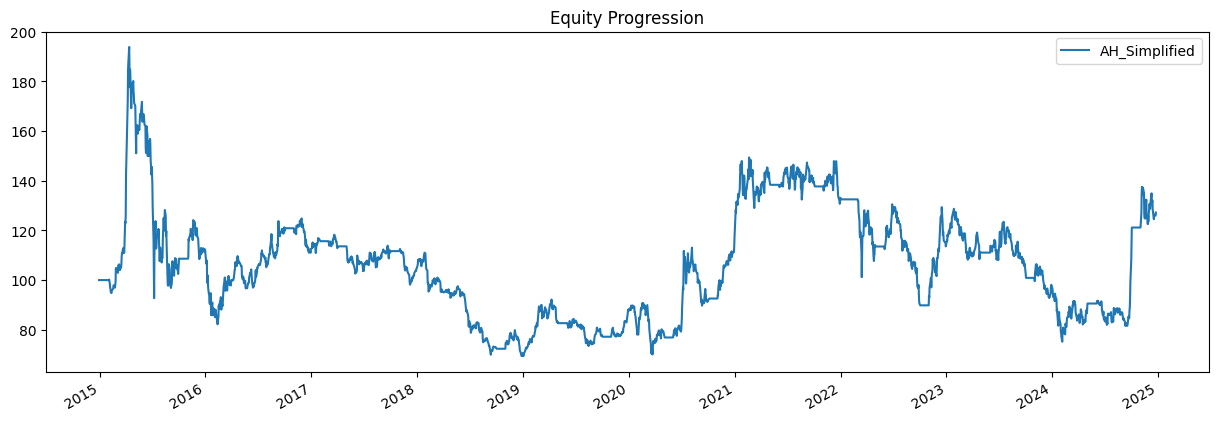

In [160]:
result.plot()

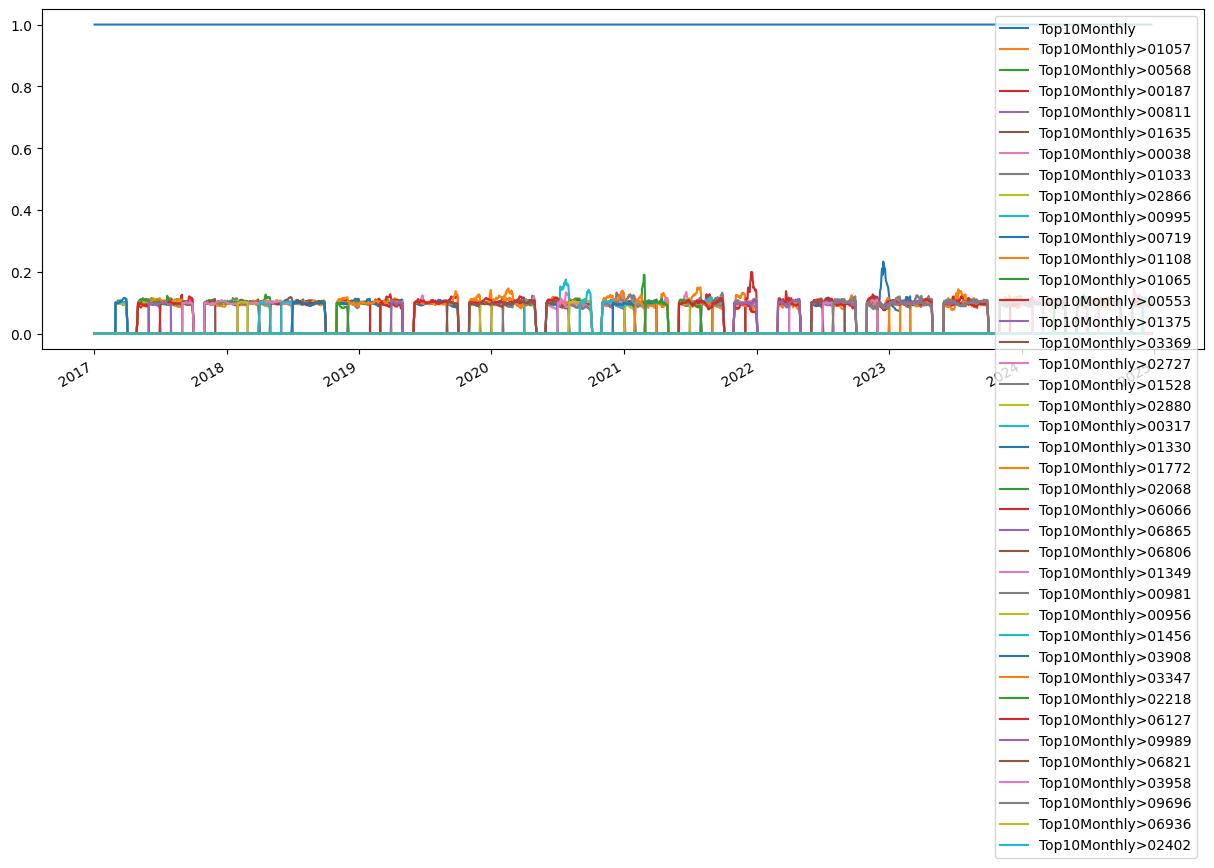

In [152]:
result.plot_weights()

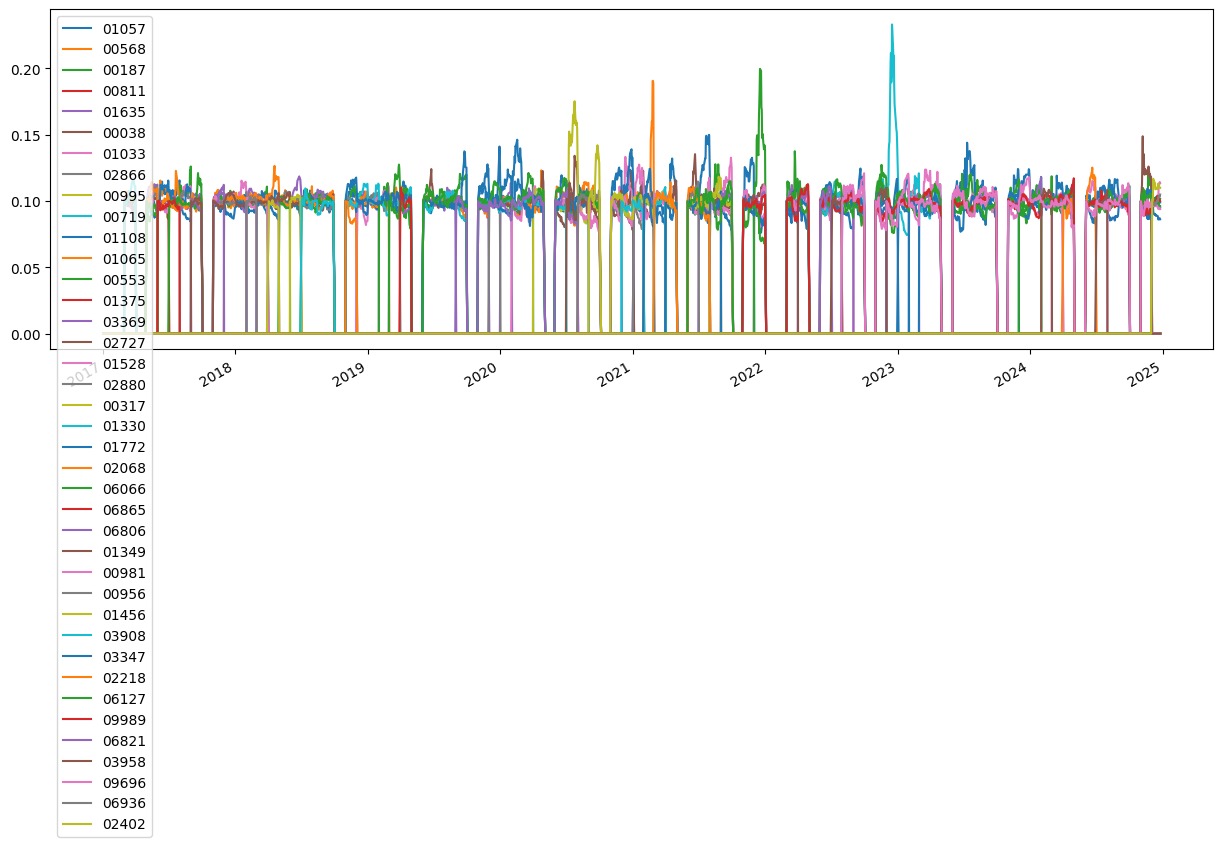

In [153]:
result.plot_security_weights()

In [161]:
result.get_transactions().to_csv("transactions.csv")

In [162]:
result.get_transactions()

price  quantity
Date       Security                   
2015-02-02 00038      5.3500   18691.0
           00187      3.1100   32154.0
           00568      3.1100   32154.0
           00719      3.6400   27472.0
           01033      2.5100   39840.0
...                      ...       ...
2024-12-02 03347     36.1111     461.0
           06127     27.8690      93.0
           06936     33.8000    3866.0
           09696     31.9831     286.0
           09989      4.4747    2839.0

[1294 rows x 2 columns]

In [163]:
result.display_monthly_returns()

  Year     Jan    Feb     Mar    Apr    May     Jun     Jul    Aug     Sep    Oct    Nov    Dec     YTD
------  ------  -----  ------  -----  -----  ------  ------  -----  ------  -----  -----  -----  ------
  2014    0      0       0      0      0       0       0      0       0      0      0      0       0
  2015    0      4.9    17.18  39.36  -4.41  -11.08  -24.86  -4.76    0.24   3.99   8.58  -4.96   12.08
  2016  -20.95   1.04   11.73   6.85  -5.29    4.32   -0.39   4.63    8.8    0.96   0.53  -7.34    0.46
  2017    3.53  -0.78   -2.43   0.66  -8.28   -0.53    3.98   2.02    1      0.57  -7.91   1.52   -7.28
  2018    1.96  -5.51   -5.15  -0.62  -1.01  -11      -0.89  -8.49   -3.55  -0.97   5.14  -7.17  -32.36
  2019    6.07  16.62   -2.09  -2.54  -0.83    0.35   -4.27  -6.53    5.04  -0.99   0.45  13      24.08
  2020  -10.3    9.27  -11.8    4.89  -3.21    3.82   32.05  -6.06   -7.41   0.97  14.04  11.4    34.24
  2021   14.12   5.64   -5.24   4.62  -1.57    5.02   -3.19   0.66 

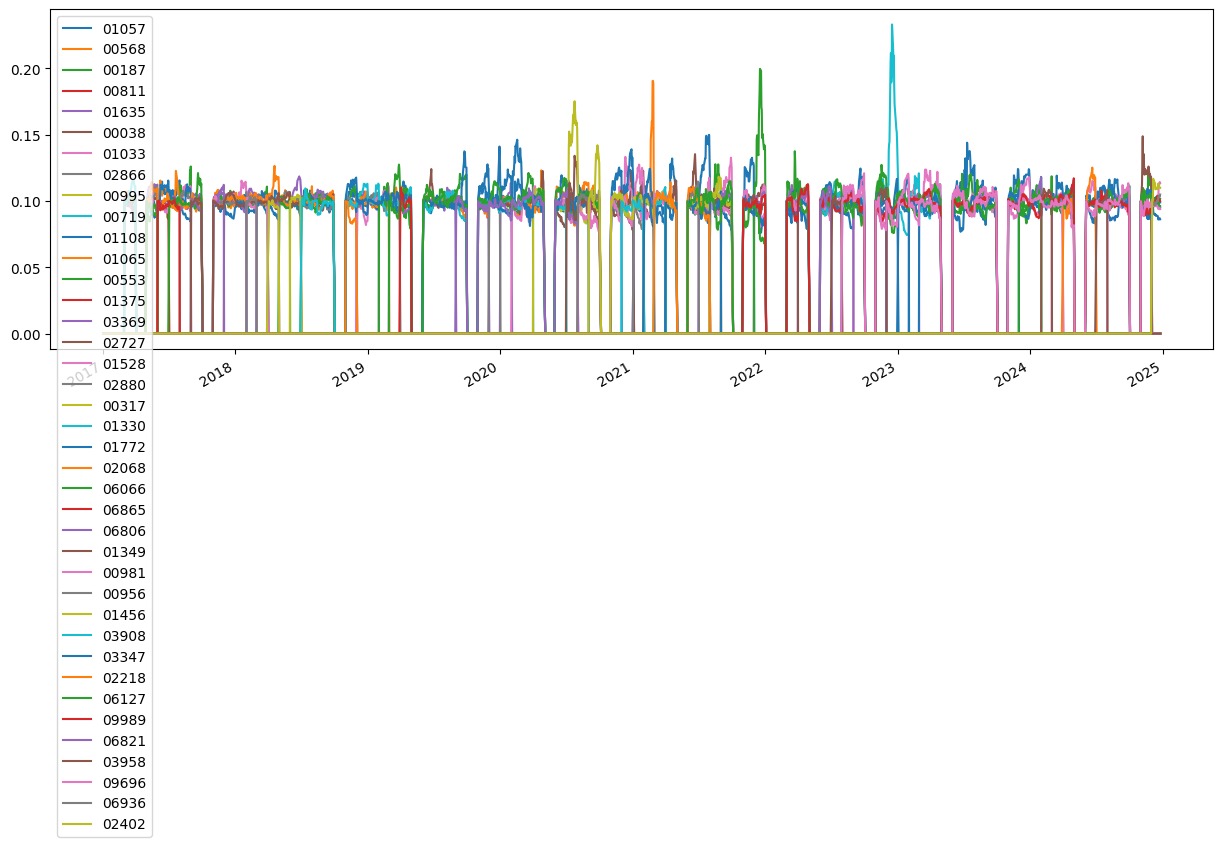

In [157]:
result.plot_security_weights()

AH premium streategy backtest